<a href="https://colab.research.google.com/github/EstebanPerez25/01.04.2025_CNN-LSTM/blob/main/Forecasting_with_1D_CNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting with 1D CNN and LSTM

Once again, we'll work with the weather time series dataset collected at the weather station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

Keep in mind that dataset includes 14 different variables such as air temperature, air pressure, humidity, wind direction and others, recorded every 10 minutes over several years. While the original data go back to 2003, our focus here is on the data from 2009 to 2016. Our goal is to construct a model that takes recent historical data (a few days' worth of data points) as input and predicts the air temperature 24 hours into the future.

You can obtain and decompress the data using the following instructions:

In [ ]:
%%bash
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip

By the way, the following code is a modified version of the code that can be found in [1]. That said, let us begin by importing some useful libraries and modules.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

The following lines of code will open the `csv` file that was downloaded and store that information in the variable named `data`.

In [ ]:
data_dir = '/content/jena_climate'
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


We can see that we're working with 14 variables and 420,551 registers. In the following cell, we'll create two `NumPy` arrays: one for the temperature variable (`temperature`), and another one for all the data (`raw_data`).  

In [ ]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Here is the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the yearly periodicity of temperature.

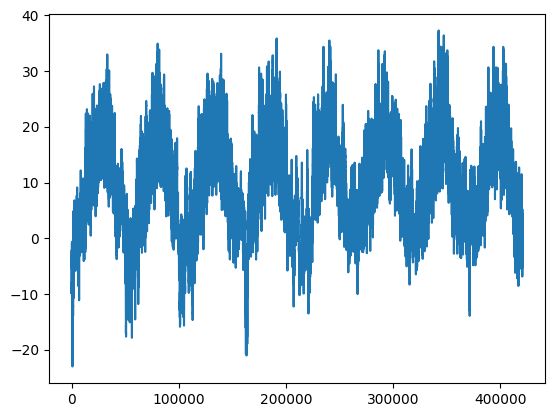

In [ ]:
plt.plot(range(len(temperature)), temperature);

By the way, it is recommended that you always look for periodicity in your data. Time series data usually have periodicity on different time scales, so it's important to find these patterns so that the models we train can learn them.

In the next steps we'll allocate 50% of the data to training, 25% to validation and the remainder to testing. When dealing with time series data, it's important to ensure that the validation and test data sets are more recent than the training data. This is because our goal is to predict the future based on past observations, not to predict the past based on the future.

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", f"{num_train_samples:,}")
print("num_val_samples:", f"{num_val_samples:,}")
print("num_test_samples:", f"{num_test_samples:,}")

num_train_samples: 210,225
num_val_samples: 105,112
num_test_samples: 105,114


## Formulation of the problem



The problem we will be solving goes as follows: given data going as far back as `sequence_length` timesteps (a timestep is 10 minutes) and sampled every `sampling_rate` timesteps, can we predict the temperature in `delay` timesteps? We will use the following parameter values:

- `sequence_length`: 120—Observations will go back 5 days.
- `sampling_rate`: 6—Observations will be sampled at one data point per hour.
- `delay`: Targets will be 24 hours after the end of the sequence.

## Preparing the data

Each time series in the dataset operates on a different scale: for example, temperature typically ranges between -20 and +30, whereas atmospheric pressure, measured in mbar, hovers around 1,000. To deal with this, we'll normalize each time series independently, ensuring that they all have small values within a comparable scale.

In [ ]:
mean = raw_data[: num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[: num_train_samples].std(axis=0)
raw_data /= std

Next, we'll construct a `dataset` object that produces batches of data over the past five days, along with a target temperature for 24 hours into the future.

As before, we could write a `Python` generator to do this, however, `Keras`  provides a handy built-in dataset utility (`timeseries_dataset_from_array()`). As expected, we'll use this utility to instantiate three datasets: one fore training, one for validation, and one for testing.

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Every dataset provides a tuple (`samples`, `targets`), where samples represent a batch of 256 samples. Each `sample` comprises 120 consecutive hours of input data, while `targets` consist of the corresponding array of 256 target temperatures. It's important to note that the samples are shuffled randomly, meaning that two consecutive sequences in a batch (such as `samples[0]` and `samples[1]`) may not be temporally adjacent.

## A common-sense baseline

In this scenario, we can reasonably assume that the temperature timeseries is continuous (tomorrow's temperatures are expected to be similar to today's) and periodic, with a daily cycle. Therefore, a straightforward approach is to predict that the temperature 24 hours from now will be the same as the current temperature. We'll assess this method using the mean absolute error (MAE) metric.

In [ ]:
def evaluate_naive_method(dataset):

    total_abs_err = 0.
    samples_seen = 0

    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]

    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This simple baseline results in a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. Therefore, predicting that the temperature 24 hours ahead will be identical to the current temperature leads to an average error of around two and a half degrees. This said, we'd expect our models to do better than this.  

## 1D convolutional model

Regarding harnessing appropriate architectural priors, given that our input sequences exhibit daily cycles, it's worth considering a convolutional model. A temporal convolutional network could effectively reuse representations across different days, similar to how a spatial convolutional network can reuse representations across distinct locations in an image.

Most likely, if you have worked with images and neural networks, you're already familiar with `Conv2D` and `SeparableConv2D` layers, which process inputs using small sliding windows over 2D grids. Additionally, there are 1D and even 3D versions of these layers: `Conv1D`, `SeparableConv1D`, and `Conv3D`. The `Conv1D` layer operates with 1D sliding windows over input sequences, while the `Conv3D` layer employs cubic windows across input volumes.

Following the *translation invariance assumption*, it makes sense to construct 1D convolutional networks, analogous to their 2D counterparts, which are well-suited for sequence data . This assumption implies that the properties within a window remain consistent regardless of its position within the sequence.

We'll begin with an initial window length of 24, enabling us to analyze 24 hours of data in each cycle. As we downsample the sequences using `MaxPooling1D` layers, we'll adjust the window size accordingly.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 73s 87ms/step - loss: 21.6556 - mae: 3.6502 - val_loss: 15.5561 - val_mae: 3.1326
Epoch 2/10
819/819 [==============================] - 70s 85ms/step - loss: 15.4654 - mae: 3.1227 - val_loss: 18.0415 - val_mae: 3.4002
Epoch 3/10
819/819 [==============================] - 73s 89ms/step - loss: 14.1567 - mae: 2.9859 - val_loss: 14.3694 - val_mae: 2.9791
Epoch 4/10
819/819 [==============================] - 71s 86ms/step - loss: 13.2683 - mae: 2.8898 - val_loss: 15.5759 - val_mae: 3.1075
Epoch 5/10
819/819 [==============================] - 75s 91ms/step - loss: 12.5666 - mae: 2.8083 - val_loss: 14.3492 - val_mae: 2.9830
Epoch 6/10
819/819 [==============================] - 76s 93ms/step - loss: 12.0133 - mae: 2.7410 - val_loss: 13.8184 - val_mae: 2.9215
Epoch 7/10
819/819 [==============================] - 83s 101ms/step - loss: 11.5581 - mae: 2.6876 - val_loss: 14.5951 - val_mae: 3.0008
Epoch 8/10
819/819 [===========================

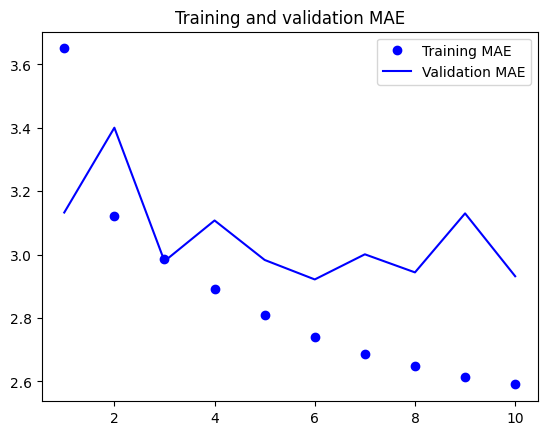

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Unfortunately, this model only achieves a validation MAE of approximately 2.9 degrees, which is significantly higher than the common-sense baseline. Two main factors are causing this result:

- Firstly, weather data doesn't adhere well to the translation invariance assumption. Although it exhibits daily cycles, the characteristics of morning data differ from those of evening or night time data. Weather data only exhibits translation invariance on a specific timescale.

- Secondly, the order of our data is crucial. Recent data is much more informative for predicting the temperature of the following day compared to data from several days prior. A 1D convolutional network is unable to leverage this importance of chronological order. Specifically, our max pooling and global average pooling layers are largely eliminating crucial order information.

## A simple LSTM-based model

As you may be aware, there exists a category of neural network architectures tailored for sequential data, known as *Recurrent Neural Networks* (RNNs). Within this family, the *Long Short Term Memory* (LSTM) layer has gained considerable popularity over time. Let's experiment with incorporating the LSTM layer into our model.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 58ms/step - loss: 39.4734 - mae: 4.5556 - val_loss: 12.0109 - val_mae: 2.6404
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 10.8041 - mae: 2.5514 - val_loss: 10.0889 - val_mae: 2.4621
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 9.8664 - mae: 2.4394 - val_loss: 9.5304 - val_mae: 2.3984
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 9.4598 - mae: 2.3846 - val_loss: 9.6344 - val_mae: 2.4089
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 9.1302 - mae: 2.3441 - val_loss: 9.8628 - val_mae: 2.4413
Epoch 6/10
819/819 [==============================] - 47s 58ms/step - loss: 8.8723 - mae: 2.3106 - val_loss: 9.8698 - val_mae: 2.4512
Epoch 7/10
819/819 [==============================] - 44s 54ms/step - loss: 8.6832 - mae: 2.2874 - val_loss: 10.1256 - val_mae: 2.4833
Epoch 8/10
819/819 [==============================] - 46s

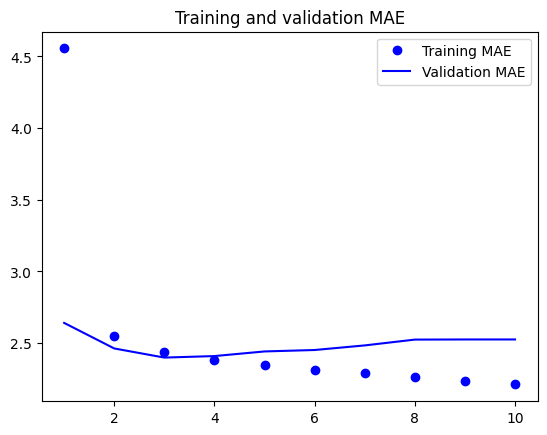

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

We managed to reach a validation MAE of about 2.36 degrees and a test MAE of 2.55 degrees approximately. The LSTM-based approach outperforms the common-sense baseline, although the improvement is modest.

## References

[1] Chollet, Francois. *Deep learning with Python*. Simon and Schuster, 2021.